# Running SIPSim pipeline to simulate priming_exp gradient dataset

* Basing simulation params off of priming_exp dataset
  * Basing starting community diversity on mean percent abundances in all fraction samples for the gradient
  * Other parameters are 'default'
  * OTU Table
    * Total community abundance = 1e9
    * Adding PCR simulation step
    * Subsampling (sequencing simulation)
    * Adding count error drawn from a neg-binomial distribution

# Setting variables

In [22]:
workDir = '/home/nick/notebook/SIPSim/dev/priming_exp/validation_sample/X12C.700.14_fracRichness-PCR-negBin/'
genomeDir = '/home/nick/notebook/SIPSim/dev/priming_exp/genomes/'
allAmpFrags = '/home/nick/notebook/SIPSim/dev/bac_genome1210/validation/ampFrags.pkl'
otuTableFile = '/var/seq_data/priming_exp/data/otu_table.txt'
metaDataFile = '/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt'
primerFile = '/home/nick/notebook/SIPSim/dev/515F-806R.fna'

cdhit_dir = '/home/nick/notebook/SIPSim/dev/priming_exp/CD-HIT/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/'

# simulation params
comm_richness =  6606
seq_per_fraction = ['lognormal', 10.096, 1.116]

# for making genome_map file for genome fragment simulation
taxonMapFile = os.path.join(cdhit_dir, 'target_taxa.txt')
genomeFilterFile = os.path.join(cdhit_dir, 'genomeFile_seqID_filt.txt')
abundFile = os.path.join('/home/nick/notebook/SIPSim/dev/priming_exp/exp_info', 'X12C.700.14_frac_OTU.txt')

# misc
nprocs = 20

# Init

In [23]:
import glob
import cPickle as pickle
import copy
from IPython.display import Image

In [24]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [25]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

In [26]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Creating a community file from the fraction relative abundances

In [27]:
%%R -i abundFile
# reading priming experiment OTU table
tbl.abund = read.delim(abundFile, sep='\t')
tbl.abund %>% head(n=4)

     OTUId mean_perc_abund median_perc_abund max_perc_abund      sample
1    OTU.1      3.82753232        3.92631730     5.60316872 X12C.700.14
2   OTU.10      0.04863100        0.04818209     0.08545617 X12C.700.14
3  OTU.100      0.30885091        0.31216647     0.50846009 X12C.700.14
4 OTU.1000      0.01354891        0.01388383     0.02444091 X12C.700.14


In [28]:
%%R
tbl.comm = tbl.abund %>%
    rename('taxon_name' = OTUId,
           'rel_abund_perc' = mean_perc_abund) %>%
    select(taxon_name, rel_abund_perc) %>%
    mutate(library = '1',
           rank = row_number(-rel_abund_perc)) %>%
    arrange(rank)
    
tbl.comm %>% head(n=4)

  taxon_name rel_abund_perc library rank
1      OTU.1       3.827532       1    1
2     OTU.68       2.088559       1    2
3      OTU.8       1.422617       1    3
4      OTU.3       1.315828       1    4


In [29]:
%%R
# rescaling rel_abund_perc so sum(rel_abund_perc) = 100
tbl.comm = tbl.comm %>%
    group_by(library) %>%
    mutate(total = sum(rel_abund_perc)) %>% 
    ungroup() %>%
    mutate(rel_abund_perc = rel_abund_perc * 100 / total) %>%
    select(library, taxon_name, rel_abund_perc, rank)
    
tbl.comm %>% head(n=4)

Source: local data frame [4 x 4]

  library taxon_name rel_abund_perc  rank
    (chr)     (fctr)          (dbl) (int)
1       1      OTU.1       3.194891     1
2       1     OTU.68       1.743347     2
3       1      OTU.8       1.187477     3
4       1      OTU.3       1.098338     4


In [30]:
%%R -i comm_richness
# number of OTUs
n.OTUs = tbl.comm$taxon_name %>% unique %>% length
cat('Number of OTUs:', n.OTUs, '\n')

# assertion
cat('Community richness = number of OTUs?  ', comm_richness == n.OTUs, '\n')

Number of OTUs: 6606 
Community richness = number of OTUs?   TRUE 


In [32]:
%%R -i workDir

commFile = paste(c(workDir, 'comm.txt'), collapse='/')
write.table(tbl.comm, commFile, sep='\t', quote=F, row.names=F)

### Plotting community distribution

In [33]:
%%R -i workDir

commFile = paste(c(workDir, 'comm.txt'), collapse='/')
comm = read.delim(commFile, sep='\t')
comm %>% head(n=4)

  library taxon_name rel_abund_perc rank
1       1      OTU.1       3.194891    1
2       1     OTU.68       1.743347    2
3       1      OTU.8       1.187477    3
4       1      OTU.3       1.098338    4


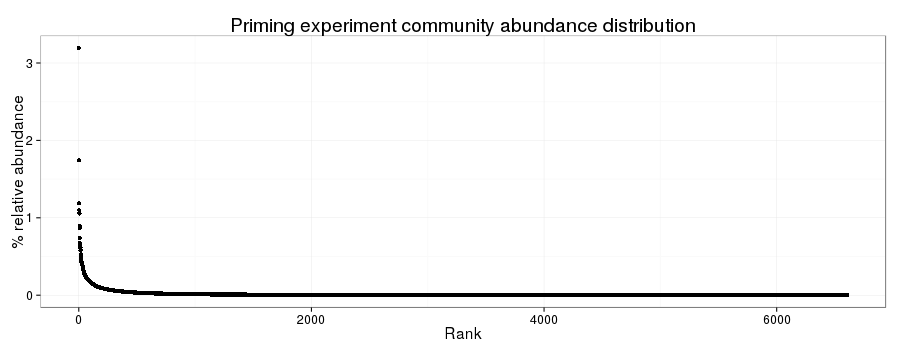

In [34]:
%%R -w 900 -h 350

ggplot(comm, aes(rank, rel_abund_perc)) +
    geom_point() +
    labs(x='Rank', y='% relative abundance', title='Priming experiment community abundance distribution') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Simulating fragments

## Making a genome index file to map genome fasta files to OTUs

* Will be used for community simulation
* Just OTUs with association to genomes

In [35]:
%%R -i taxonMapFile -i genomeFilterFile 

taxonMap = read.delim(taxonMapFile, sep='\t') %>%
    select(target_genome, OTU) %>%
    distinct()
taxonMap %>% nrow %>% print
taxonMap %>% head(n=3) %>% print

breaker = '----------------\n'
cat(breaker)

genomeFilter = read.delim(genomeFilterFile, sep='\t', header=F) 
genomeFilter %>% nrow %>% print
genomeFilter %>% head(n=3) %>% print

cat(breaker)

comm = read.delim(commFile, sep='\t') 
comm %>% nrow %>% print
comm %>% head(n=3) %>% print

[1] 236
                               target_genome      OTU
1 CP001738_Thermomonospora_curvata_DSM_43183 OTU.8540
2 CP001738_Thermomonospora_curvata_DSM_43183 OTU.9267
3 CP001738_Thermomonospora_curvata_DSM_43183 OTU.1457
----------------
[1] 187
                                                         V1
1                  CP003093_Pseudoxanthomonas_spadix_BD_a59
2                  CP000511_Mycobacterium_vanbaalenii_PYR_1
3 CP003344_Desulfitobacterium_dichloroeliminans_LMG_P_21439
                                                                                                            V2
1                  /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Pseudoxanthomonas_spadix_BD-a59.fasta
2                  /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Mycobacterium_vanbaalenii_PYR-1.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Desulfitobacterium_dichloroeliminans_LMG_P-21439.fasta
----------------
[1] 6606
  library taxon_name rel_abund_perc rank


In [36]:
%%R
taxonMap$OTU %>% table %>% sort(decreasing=T) %>% head

.
    OTU.1    OTU.10   OTU.101   OTU.102 OTU.10237  OTU.1035 
        1         1         1         1         1         1 


In [37]:
%%R

tbl.j = inner_join(taxonMap, genomeFilter, c('target_genome' = 'V1')) %>%
     rename('fasta_file' = V2) %>%
     select(OTU, fasta_file, target_genome)

tbl.j %>% head(n=3)

       OTU
1 OTU.8540
2 OTU.9267
3 OTU.1457
                                                                                     fasta_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
                               target_genome
1 CP001738_Thermomonospora_curvata_DSM_43183
2 CP001738_Thermomonospora_curvata_DSM_43183
3 CP001738_Thermomonospora_curvata_DSM_43183


In [38]:
%%R
tbl.j$OTU %>% table %>% sort(decreasing=T) %>% head

.
    OTU.1    OTU.10   OTU.101   OTU.102 OTU.10237  OTU.1035 
        1         1         1         1         1         1 


In [39]:
%%R
tbl.j2 = inner_join(tbl.j, comm, c('OTU' = 'taxon_name')) 

n.target.genomes = tbl.j2$OTU %>% unique %>% length
cat('Number of target OTUs: ', n.target.genomes, '\n')
cat('--------', '\n')
tbl.j2 %>% head(n=3)

Number of target OTUs:  198 
-------- 
       OTU
1 OTU.8540
2 OTU.9267
3 OTU.1457
                                                                                     fasta_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
                               target_genome library rel_abund_perc rank
1 CP001738_Thermomonospora_curvata_DSM_43183       1    0.002582583 4561
2 CP001738_Thermomonospora_curvata_DSM_43183       1    0.005045402 2191
3 CP001738_Thermomonospora_curvata_DSM_43183       1    0.011258918 1106


In [40]:
%%R -i workDir

outFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')
write.table(tbl.j2, outFile, sep='\t', quote=F, row.names=F, col.names=F)

## Plotting community abundance distribution of target genomes

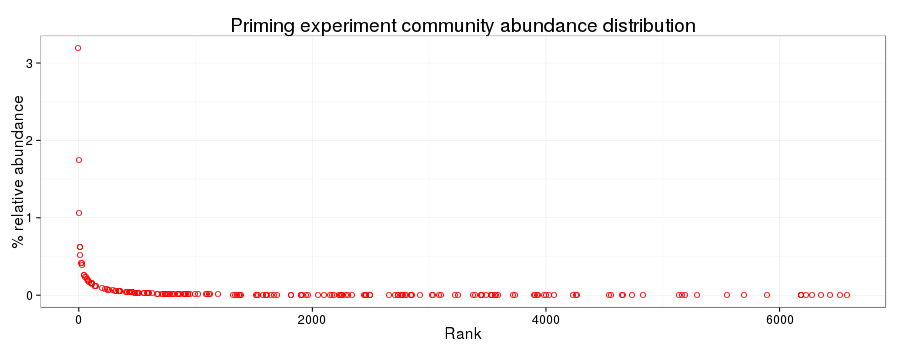

In [41]:
%%R -w 900 -h 350

ggplot(tbl.j2, aes(rank, rel_abund_perc)) +
    geom_point(size=3, shape='O', color='red') +
    labs(x='Rank', y='% relative abundance', title='Priming experiment community abundance distribution') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Simulating fragments of genomes that match priming_exp bulk OTUs

In [42]:
!cd $workDir; \
    SIPSim fragments \
    target_genome_index.txt \
    --fp $genomeDir \
    --fr $primerFile \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    2> ampFrags.log \
    > ampFrags.pkl        

## Appending fragments from randomly selected genomes of total dataset (n=1210)

* This is to obtain the richness of the bulk soil community
* Random OTUs will be named after non-target OTUs in comm file

### Making list of non-target OTUs

In [46]:
%%R -i workDir
# loading files

## target genome index (just OTUs with associated genome)
inFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')
tbl.target = read.delim(inFile, sep='\t', header=F)
colnames(tbl.target) = c('OTUId', 'fasta_file', 'genome_name')

## comm file of total community OTUs 
commFile = paste(c(workDir, 'comm.txt'), collapse='/')
tbl.comm = read.delim(commFile, sep='\t')

In [47]:
%%R
# just OTUs w/out an associated genome
tbl.j = anti_join(tbl.comm, tbl.target, c('taxon_name' = 'OTUId'))
n.nontarget.genomes = tbl.j$taxon_name %>% length
cat('Number of non-target genomes: ', n.nontarget.genomes, '\n')
cat('---------\n')
tbl.j %>% head(n=5)

Number of non-target genomes:  6408 
---------
  library taxon_name rel_abund_perc rank
1       1   OTU.9280   0.0008491831 6606
2       1   OTU.8991   0.0008491831 6605
3       1   OTU.8467   0.0008491831 6604
4       1   OTU.7687   0.0008491831 6603
5       1   OTU.7201   0.0008491831 6602


In [48]:
%%R -i comm_richness
# checking assumptions
cat('Target + nonTarget richness = total community richness?: ',
    n.target.genomes + n.nontarget.genomes == comm_richness, '\n')

Target + nonTarget richness = total community richness?:  TRUE 


In [49]:
%%R -i workDir
# writing out non-target OTU file
outFile = paste(c(workDir, 'comm_nonTarget.txt'), collapse='/')
write.table(tbl.j, outFile, sep='\t', quote=F, row.names=F)

### Randomly selecting amplicon fragment length-GC KDEs from total genome pool

In [50]:
# List of non-target OTUs
inFile = os.path.join(workDir, 'comm_nonTarget.txt')
nonTarget = pd.read_csv(inFile, sep='\t')['taxon_name'].tolist()

print 'Number of non-target OTUs: {}'.format(len(nonTarget))
nonTarget[:4]

Number of non-target OTUs: 6408


['OTU.9280', 'OTU.8991', 'OTU.8467', 'OTU.7687']

In [51]:
# loading amplicon fragments from full genome KDE dataset
inFile = os.path.join(workDir, 'ampFrags.pkl')
ampFrag_target = []
with open(inFile, 'rb') as iFH:
    ampFrag_target = pickle.load(iFH)
print 'Target OTU richness: {}'.format(len(ampFrag_target))

Target OTU richness: 198


In [52]:
# loading amplicon fragments from full genome KDE dataset
ampFrag_all = []
with open(allAmpFrags, 'rb') as iFH:
    ampFrag_all = pickle.load(iFH)
print 'Count of frag-GC KDEs for all genomes: {}'.format(len(ampFrag_all))    

Count of frag-GC KDEs for all genomes: 1210


In [53]:
# random selection from list
#target_richness = len(ampFrag_target)

target_richness = len(ampFrag_target)
richness_needed = comm_richness - target_richness
print 'Number of random taxa needed to reach richness: {}'.format(richness_needed)

if richness_needed > 0:
    index = range(target_richness)
    index = np.random.choice(index, richness_needed)
    
    ampFrag_rand = []
    for i in index:
        sys.stderr.write('{},'.format(i))
        ampFrag_rand.append(copy.deepcopy(ampFrag_all[i]))
else:
    ampFrag_rand = []

101,25,171,16,146,36,155,192,80,131,40,110,144,121,170,118,77,49,44,31,142,167,23,190,113,3,145,126,145,182,70,130,68,46,89,119,96,56,173,70,175,72,170,145,124,95,41,107,110,55,31,32,188,135,97,142,189,162,121,37,3,123,119,160,43,177,44,74,77,85,94,162,18,67,98,153,119,14,132,151,63,158,57,10,0,151,52,118,152,145,55,189,16,78,56,8,10,76,176,26,122,22,124,48,113,78,1,13,185,94,144,124,99,34,142,38,116,111,139,140,3,9,177,139,182,163,124,120,114,90,81,190,159,21,72,143,2,125,28,54,92,97,21,61,52,183,94,109,91,185,170,91,97,37,146,152,48,104,106,146,150,19,37,69,15,25,92,129,140,99,141,169,145,127,49,124,5,109,1,152,1,82,188,164,54,25,137,149,20,139,182,136,48,156,26,125,121,1,77,171,36,43,168,87,47,131,168,107,84,142,0,62,187,160,98,103,173,54,141,140,182,25,14,122,66,131,116,123,130,56,167,25,131,136,120,12,188,0,117,101,70,138,11,22,149,45,133,81,98,139,111,190,82,96,39,14,50,108,65,100,98,28,32,196,124,74,0,50,21,55,68,78,140,178,171,190,120,5,109,187,137,57,69,2,99,71,32,130,62,129,1

Number of random taxa needed to reach richness: 6408


44,

In [54]:
# renaming randomly selected KDEs by non-target OTU-ID
for i in range(len(ampFrag_rand)):
    ampFrag_rand[i][0] = nonTarget[i]

In [55]:
# appending random taxa to target taxa and writing
outFile = os.path.join(workDir, 'ampFrags_wRand.pkl')

with open(outFile, 'wb') as oFH:
    x = ampFrag_target + ampFrag_rand
    print 'Number of taxa in output: {}'.format(len(x))
    pickle.dump(x, oFH)

Number of taxa in output: 6606


# Converting fragments to kde object

In [56]:
!cd $workDir; \
    SIPSim fragment_kde \
    ampFrags_wRand.pkl \
    > ampFrags_wRand_kde.pkl

# Adding diffusion

In [57]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_wRand_kde.pkl \
    --np $nprocs \
    > ampFrags_wRand_kde_dif.pkl    

Processing: OTU.759
Processing: OTU.3200
Processing: OTU.417
Processing: OTU.4687
Processing: OTU.4684
Processing: OTU.4685
Processing: OTU.6773
Processing: OTU.757
Processing: OTU.2002
Processing: OTU.507
Processing: OTU.9232
Processing: OTU.5335
Processing: OTU.4683
Processing: OTU.1969
Processing: OTU.12933
Processing: OTU.2003
Processing: OTU.504
Processing: OTU.6231
Processing: OTU.6230
Processing: OTU.142
Processing: OTU.8214
Processing: OTU.1297
Processing: OTU.4680
Processing: OTU.12668
Processing: OTU.13575
Processing: OTU.6722
Processing: OTU.4929
Processing: OTU.505
Processing: OTU.6233
Processing: OTU.13948
Processing: OTU.5337
Processing: OTU.411
Processing: OTU.1294
Processing: OTU.4681
Processing: OTU.932
Processing: OTU.12666
Processing: OTU.13576
Processing: OTU.839
Processing: OTU.502
Processing: OTU.3604
Processing: OTU.6721
Processing: OTU.3425
Processing: OTU.13941
Processing: OTU.8216
Processing: OTU.1744
Processing: OTU.7608
Processing: OTU.4224
Processing: OTU.5

# Making an incorp config file

In [58]:
!cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 0 \
    --percIncorpUnif 100 \
    > PT0_PI100.config

# Adding isotope incorporation to BD distribution

In [59]:
!cd $workDir; \
    SIPSim isotope_incorp \
    ampFrags_wRand_kde_dif.pkl \
    PT0_PI100.config \
    --comm comm.txt \
    --np $nprocs \
    > ampFrags_wRand_kde_dif_incorp.pkl

Processing: OTU.759
Processing: OTU.3200
Processing: OTU.6773
Processing: OTU.757
Processing: OTU.417
Processing: OTU.1969
Processing: OTU.2002
Processing: OTU.589
Processing: OTU.9232
Processing: OTU.2003
Processing: OTU.12668
Processing: OTU.4741
Processing: OTU.4688
Processing: OTU.4929
Processing: OTU.142
Processing: OTU.12666
Processing: OTU.5333
Processing: OTU.506
Processing: OTU.4687
Processing: OTU.4684
Processing: OTU.4685
Processing: OTU.839
Processing: OTU.411
Processing: OTU.1965
Processing: OTU.6158
Processing: OTU.5332
Processing: OTU.507
Processing: OTU.4683
Processing: OTU.2554
Processing: OTU.140
Processing: OTU.3601
Processing: OTU.12664
Processing: OTU.12115
Processing: OTU.5335
Processing: OTU.504
Processing: OTU.1290
Processing: OTU.1291
Processing: OTU.4680
Processing: OTU.2007
Processing: OTU.4814
Processing: OTU.6236
Processing: OTU.12117
Processing: OTU.1960
Processing: OTU.8214
Processing: OTU.505
Processing: OTU.4395
Processing: OTU.4681
Processing: OTU.1296

# Calculating BD shift from isotope incorporation

In [60]:
!cd $workDir; \
    SIPSim BD_shift \
    ampFrags_wRand_kde_dif.pkl \
    ampFrags_wRand_kde_dif_incorp.pkl \
    --np $nprocs \
    > ampFrags_wRand_kde_dif_incorp_BD-shift.txt

Loading KDE objects...
Calculating BD shifts...
  Comparing libraries; "NA", "1"
  Processing: OTU.759
  Processing: OTU.3200
  Processing: OTU.417
  Processing: OTU.4687
  Processing: OTU.4684
  Processing: OTU.4685
  Processing: OTU.6773
  Processing: OTU.757
  Processing: OTU.507
  Processing: OTU.2002
  Processing: OTU.9232
  Processing: OTU.5335
  Processing: OTU.13575
  Processing: OTU.4683
  Processing: OTU.1969
  Processing: OTU.3604
  Processing: OTU.2003
  Processing: OTU.504
  Processing: OTU.7608
  Processing: OTU.142
  Processing: OTU.8214
  Processing: OTU.6727
  Processing: OTU.7048
  Processing: OTU.13576
  Processing: OTU.4680
  Processing: OTU.12668
  Processing: OTU.13941
  Processing: OTU.505
  Processing: OTU.4929
  Processing: OTU.7045
  Processing: OTU.930
  Processing: OTU.9278
  Processing: OTU.411
  Processing: OTU.5337
  Processing: OTU.6726
  Processing: OTU.7874
  Processing: OTU.12666
  Processing: OTU.4681
  Processing: OTU.3399
  Processing: OTU.839
  Pr

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


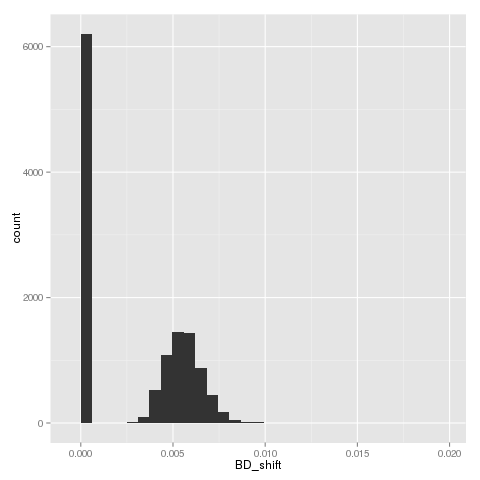

In [61]:
%%R -i workDir
# plotting BD-shift counts

setwd(workDir)
df = read.delim('ampFrags_wRand_kde_dif_incorp_BD-shift.txt', sep='\t')

ggplot(df, aes(BD_shift)) +
    geom_histogram()

# Simulating gradient fractions

In [62]:
!cd $workDir; \
    SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt

# Simulating an OTU table

In [63]:
!cd $workDir; \
    SIPSim OTU_table \
    ampFrags_wRand_kde_dif_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 5e9 \
    --np $nprocs \
    > OTU_abs5e9.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "OTU.1"
   taxon abs-abundance:  159744554
  Processing taxon: "OTU.159"
   taxon abs-abundance:  9618842
  Processing taxon: "OTU.129"
   taxon abs-abundance:  5324969
  Processing taxon: "OTU.98"
   taxon abs-abundance:  3700347
  Processing taxon: "OTU.270"
   taxon abs-abundance:  2730413
  Processing taxon: "OTU.177"
   taxon abs-abundance:  2117272
  Processing taxon: "OTU.5917"
   taxon abs-abundance:  1670863
  Processing taxon: "OTU.3332"
   taxon abs-abundance:  1395964
  Processing taxon: "OTU.2144"
   taxon abs-abundance:  1142654
  Processing taxon: "OTU.8004"
  Processing taxon: "OTU.6767"
   taxon abs-abundance:  2727189
   taxon abs-abundance:  2113842
  Processing taxon: "OTU.669"
   taxon abs-abundance:  985465
  Processing taxon: "OTU.1128"
   taxon abs-abundance:  1667363
  Processing taxon: "OTU.1814"
   taxon abs-abundance:  1664467
  Processing taxon: "OTU.5914"
   taxon abs-abundance

## Plotting taxon abundances

In [64]:
%%R -i workDir
setwd(workDir)

# loading file
tbl = read.delim('OTU_abs5e9.txt', sep='\t')

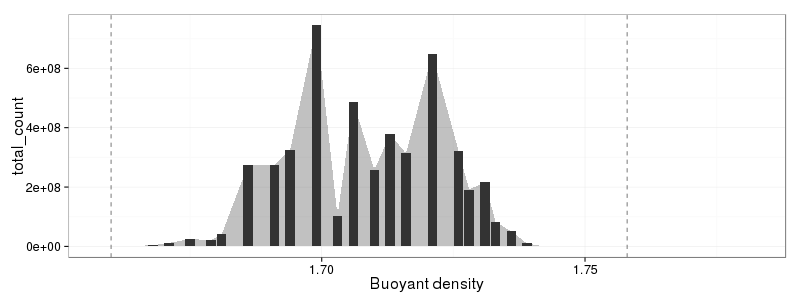

In [65]:
%%R -w 800 -h 300
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count))

## plot
p = ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

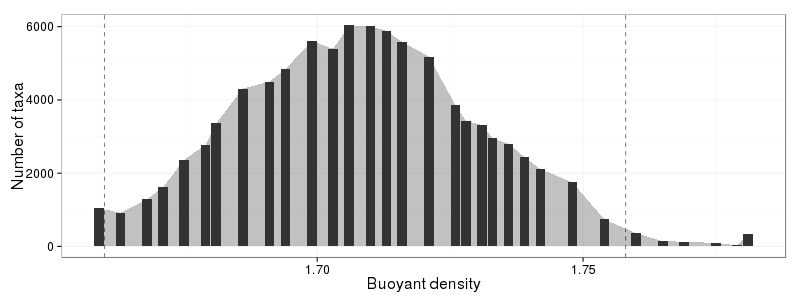

In [66]:
%%R -w 800 -h 300
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_mid, n_taxa)) +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

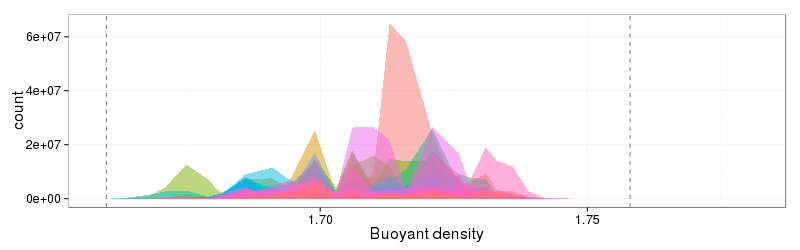

In [67]:
%%R -w 800 -h 250
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

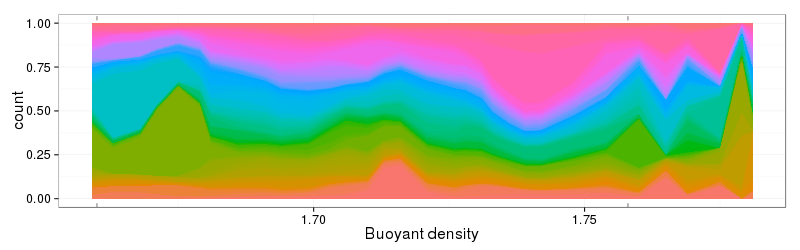

In [68]:
%%R -w 800 -h 250

p + geom_area(stat='identity', position='fill')

# Simulating PCR 

In [110]:
!cd $workDir; \
    SIPSim OTU_PCR \
    OTU_abs5e9.txt \
    > OTU_abs5e9_PCR.txt
    
!cd $workDir; \
    head -n 4 OTU_abs5e9_PCR.txt

library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	OTU.1	-inf-1.660	-inf	1.659	1.659	0	0.0
1	OTU.1	1.660-1.666	1.66	1.663	1.666	0	0.0
1	OTU.1	1.666-1.670	1.666	1.668	1.67	0	0.0


# Subsampling from the OTU table

In [112]:
dist,loc,scale = seq_per_fraction

!cd $workDir; \
    SIPSim OTU_subsample \
    --dist $dist \
    --dist_params mean:$loc,sigma:$scale \
    --walk 2 \
    --min_size 10000 \
    --max_size 200000 \
    OTU_abs5e9_PCR.txt \
    > OTU_abs5e9_PCR_sub.txt 
    
!cd $workDir; \
    head -n 4 OTU_abs5e9_PCR_sub.txt   

library	fraction	taxon	BD_min	BD_mid	BD_max	count	rel_abund
1	-inf-1.660	OTU.1	-inf	1.659	1.659	0	0.0
1	1.660-1.666	OTU.1	1.66	1.663	1.666	0	0.0
1	1.666-1.670	OTU.1	1.666	1.668	1.67	0	0.0


### Plotting sample size distribution

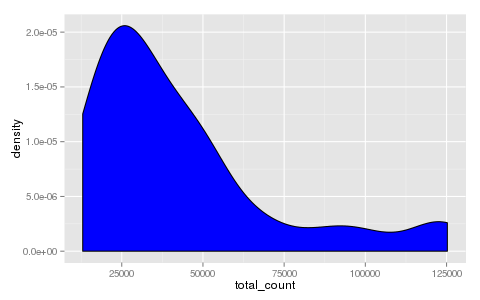

In [116]:
%%R -h 300 -i workDir
setwd(workDir)

tbl = read.csv('OTU_abs5e9_PCR_sub.txt', sep='\t') 

tbl.s = tbl %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(tbl.s, aes(total_count)) +
    geom_density(fill='blue')

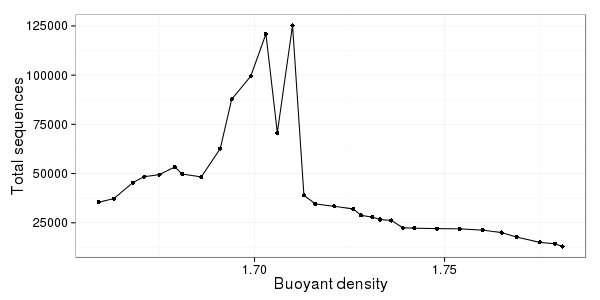

In [117]:
%%R -h 300 -w 600
setwd(workDir)

tbl.s = tbl %>%
    group_by(fraction, BD_min, BD_mid, BD_max) %>%
    summarize(total_count = sum(count)) 

ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Adding count error

In [115]:
!cd $workDir; \
    SIPSim OTU_add_error \
    OTU_abs5e9_PCR_sub.txt \
    > OTU_abs5e9_PCR_sub_negBin.txt 
    
!cd $workDir; \
    head -n 4 OTU_abs5e9_PCR_sub_negBin.txt 

library	fraction	taxon	BD_min	BD_mid	BD_max	count	rel_abund
1	-inf-1.660	OTU.1	-inf	1.659	1.659	0	0.0
1	1.660-1.666	OTU.1	1.66	1.663	1.666	0	0.0
1	1.666-1.670	OTU.1	1.666	1.668	1.67	0	0.0


## Plotting values

In [118]:
%%R -i workDir
setwd(workDir)

tbl.otu = read.delim('OTU_abs5e9.txt', sep='\t') 
tbl.otu.g = tbl.otu %>% gather('type', 'value', c(count, rel_abund))
#tbl.otu.g %>% head %>% print

tbl.otu.PCR = read.delim('OTU_abs5e9_PCR_sub_negBin.txt', sep='\t') %>%
    select(-count) 
tbl.otu.PCR.g = tbl.otu.PCR %>% gather('type', 'value', c(rel_abund)) %>%
    mutate(type = 'rel_abund_PCR_negBin')
#tbl.otu.PCR.g %>% head(n=3) %>% print

tbl.otu.c = rbind(tbl.otu.g, tbl.otu.PCR.g)
tbl.otu.c %>% head(n=3)

  library taxon    fraction BD_min BD_mid BD_max  type value
1       1 OTU.1  -inf-1.660   -Inf  1.659  1.659 count     0
2       1 OTU.1 1.660-1.666  1.660  1.663  1.666 count     0
3       1 OTU.1 1.666-1.670  1.666  1.668  1.670 count     0


### Comparing relative abundances

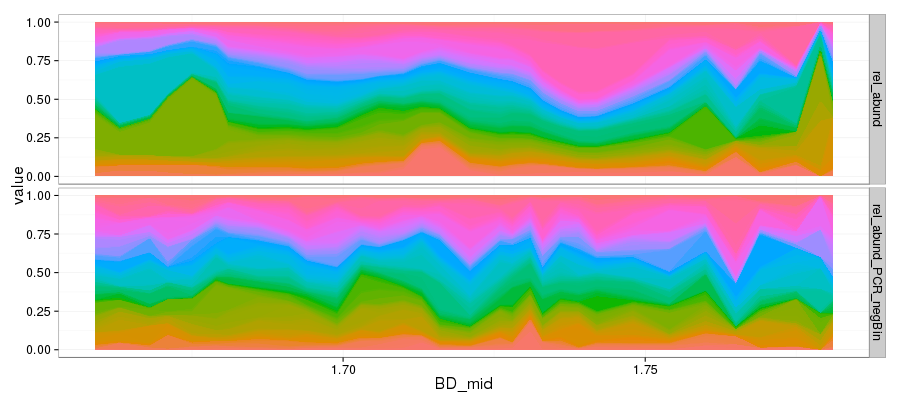

In [119]:
%%R -w 900 -h 400

tbl.otu.c.f = tbl.otu.c %>%
    filter(type != 'count')

ggplot(tbl.otu.c.f, aes(BD_mid, value, fill=taxon)) +
    geom_area() +
    facet_grid(type ~ ., scales='free_y') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

### Comparing rank-abundance distributions of each fraction

In [120]:
%%R
tbl.otu.c.f = tbl.otu.c %>%
    filter(type != 'count') %>%
    group_by(library, fraction) %>%
    mutate(rank = row_number(-value)) 
tbl.otu.c.f %>% head

Source: local data frame [6 x 9]
Groups: library, fraction [6]

  library  taxon    fraction BD_min BD_mid BD_max      type value  rank
    (int) (fctr)      (fctr)  (dbl)  (dbl)  (dbl)    (fctr) (dbl) (int)
1       1  OTU.1  -inf-1.660   -Inf  1.659  1.659 rel_abund     0  1661
2       1  OTU.1 1.660-1.666  1.660  1.663  1.666 rel_abund     0  1261
3       1  OTU.1 1.666-1.670  1.666  1.668  1.670 rel_abund     0  1656
4       1  OTU.1 1.670-1.673  1.670  1.671  1.673 rel_abund     0  1872
5       1  OTU.1 1.673-1.677  1.673  1.675  1.677 rel_abund     0  2773
6       1  OTU.1 1.677-1.680  1.677  1.679  1.680 rel_abund     0  3375


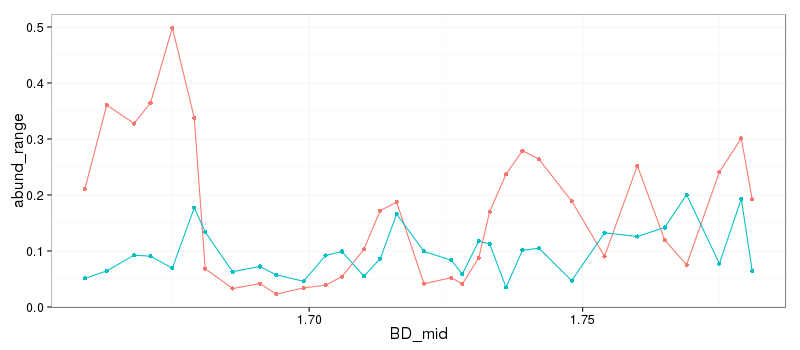

In [121]:
%%R -w 800 -h 350

tbl.otu.c.f = tbl.otu.c %>%
    filter(type != 'count') %>%
    group_by(library, fraction, BD_mid, type) %>%
    summarize(abund_range = max(value) - min(value)) 

ggplot(tbl.otu.c.f, aes(BD_mid, abund_range, color=type)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

### Distribution of median relative abundances

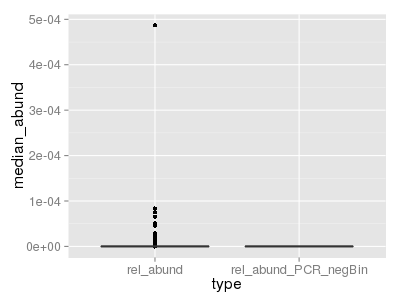

In [122]:
%%R -w 400 -h 300
tbl.otu.c.f = tbl.otu.c %>%
    filter(type != 'count') %>%
    group_by(library, type, taxon) %>%
    mutate(median_abund = median(value))

ggplot(tbl.otu.c.f, aes(type, median_abund)) +
    geom_boxplot() +
    theme(
        text = element_text(size=16)
        )

### Plotting abundance distributions of most abundant taxa

In [123]:
%%R

top.taxa = tbl.otu.c %>%
    filter(type == 'count') %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(value)) %>%
    ungroup() %>%
    top_n(10, total_count) %>%
    select(taxon) %>%
    as.matrix %>%
    as.vector
top.taxa %>% head

[1] "OTU.1"  "OTU.13" "OTU.2"  "OTU.20" "OTU.22" "OTU.3" 


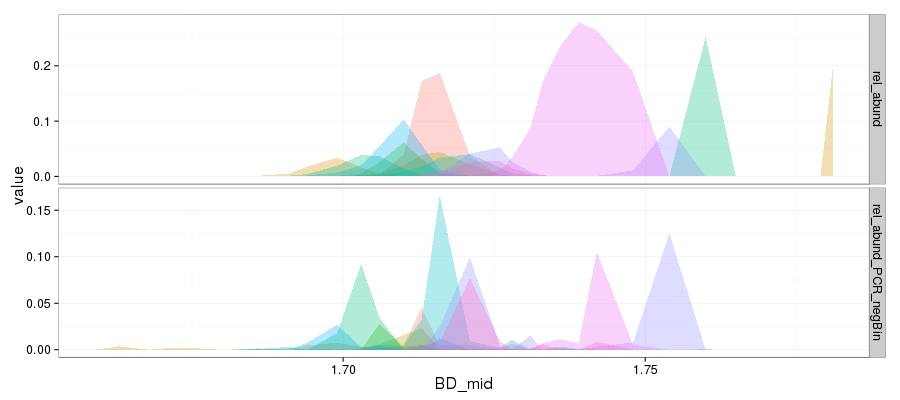

In [124]:
%%R -w 900 -h 400

tbl.otu.c.f = tbl.otu.c %>%
    filter(type != 'count',
           taxon %in% top.taxa) %>%
    group_by(library, type, taxon) %>%
    mutate(median_abund = median(value)) %>%
    ungroup()    

ggplot(tbl.otu.c.f, aes(BD_mid, value, fill=taxon)) +
    geom_area(position='dodge', alpha=0.3) +
    facet_grid(type ~ ., scales='free_y') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

## Getting list of target taxa

In [125]:
%%R -i workDir

inFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')

tbl.target = read.delim(inFile, sep='\t', header=F)
colnames(tbl.target) = c('OTUId', 'genome_file', 'genome_ID', 'X', 'Y', 'Z')
tbl.target = tbl.target %>% distinct(OTUId)


cat('Number of target OTUs: ', tbl.target$OTUId %>% unique %>% length, '\n')
cat('----------\n')
tbl.target %>% head(n=3)

Number of target OTUs:  198 
----------
     OTUId
1 OTU.8540
2 OTU.9267
3 OTU.1457
                                                                                    genome_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
                                   genome_ID X           Y    Z
1 CP001738_Thermomonospora_curvata_DSM_43183 1 0.002582583 4561
2 CP001738_Thermomonospora_curvata_DSM_43183 1 0.005045402 2191
3 CP001738_Thermomonospora_curvata_DSM_43183 1 0.011258918 1106


## Plotting abundance distributions

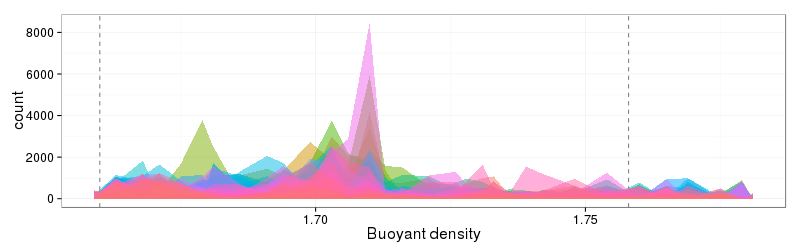

In [126]:
%%R -w 800 -h 250
# plotting relative abundances

tbl = tbl %>% 
    group_by(fraction) %>%
    mutate(rel_abund = count / sum(count))


## plot
p = ggplot(tbl, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

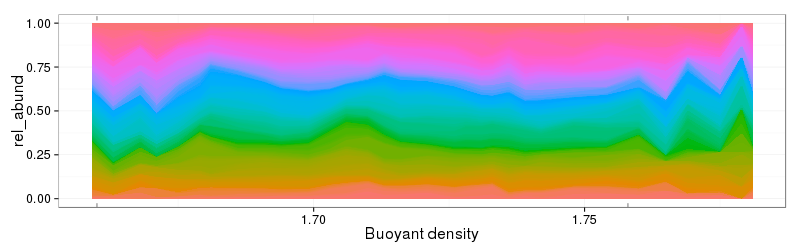

In [127]:
%%R -w 800 -h 250

p = ggplot(tbl, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity')

### Abundance distribution of just target taxa

In [128]:
%%R

targets = tbl.target$OTUId %>% as.vector %>% unique 

tbl.f = tbl %>%
    filter(taxon %in% targets)

tbl.f %>% head

Source: local data frame [6 x 8]
Groups: fraction [6]

  library    fraction  taxon BD_min BD_mid BD_max count rel_abund
    (int)      (fctr) (fctr)  (dbl)  (dbl)  (dbl) (int)     (dbl)
1       1  -inf-1.660  OTU.1   -Inf  1.659  1.659     0         0
2       1 1.660-1.666  OTU.1  1.660  1.663  1.666     0         0
3       1 1.666-1.670  OTU.1  1.666  1.668  1.670     0         0
4       1 1.670-1.673  OTU.1  1.670  1.671  1.673     0         0
5       1 1.673-1.677  OTU.1  1.673  1.675  1.677     0         0
6       1 1.677-1.680  OTU.1  1.677  1.679  1.680     0         0


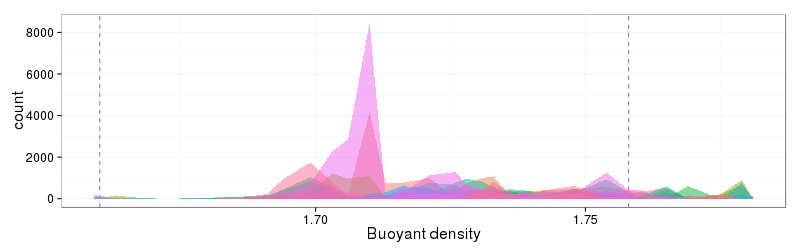

In [129]:
%%R -w 800 -h 250
# plotting absolute abundances

## plot
p = ggplot(tbl.f, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

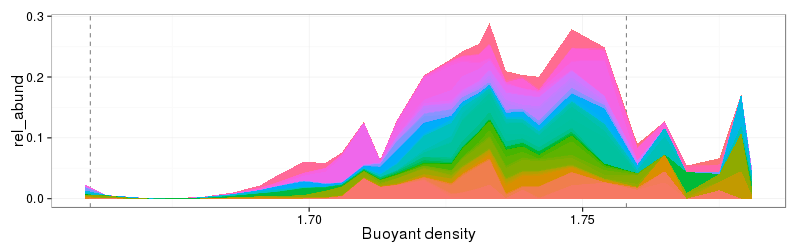

In [130]:
%%R -w 800 -h 250
# plotting relative abundances

p = ggplot(tbl.f, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity')

# Plotting 'true' taxon abundance distribution (from priming exp dataset)

In [131]:
%%R -i metaDataFile
# loading priming_exp metadata file

meta = read.delim(metaDataFile, sep='\t')
meta %>% head(n=4)

            Sample FractionNum Bulk Control CC X100 X700 H2O Day Density rep
1 12C.000.28.03.07           7    0       1  1    0    0   0  28  1.7646    
2 12C.000.28.03.08           8    0       1  1    0    0   0  28  1.7614    
3 12C.000.28.03.09           9    0       1  1    0    0   0  28  1.7537    
4 12C.000.28.03.10          10    0       1  1    0    0   0  28  1.7483    
  contolVlabel Treatment
1      control    12C000
2      control    12C000
3      control    12C000
4      control    12C000


In [132]:
%%R -i otuTableFile
# loading priming_exp OTU table 

tbl.otu.true = read.delim(otuTableFile, sep='\t') %>%
    select(OTUId, starts_with('X12C.700.14')) 
tbl.otu.true %>% head(n=3)

     OTUId X12C.700.14.06.14 X12C.700.14.06.05 X12C.700.14.06.16
1 OTU.4776                34               142                11
2 OTU.2864                 1                16                 1
3 OTU.8170                 0                 0                 0
  X12C.700.14.06.11 X12C.700.14.06.13 X12C.700.14.06.09 X12C.700.14.06.04
1                18                30                27                97
2                 2                 0                 1                 3
3                 0                 0                 0                 0
  X12C.700.14.06.20 X12C.700.14.06.10 X12C.700.14.06.15 X12C.700.14.06.08
1               226                23                19                35
2                 1                 0                 1                 0
3                 0                 1                 0                 0
  X12C.700.14.06.12 X12C.700.14.06.18 X12C.700.14.06.17 X12C.700.14.06.19
1                25                61                27               136


In [133]:
%%R
# editing table
tbl.otu.true.w = tbl.otu.true %>%
    gather('sample', 'count', 2:ncol(tbl.otu.true)) %>%
    mutate(sample = gsub('^X', '', sample)) %>%
    group_by(sample) %>%
    mutate(rel_abund = count / sum(count)) %>%
    ungroup() %>%
    filter(count > 0)
tbl.otu.true.w %>% head(n=5)

Source: local data frame [5 x 4]

     OTUId           sample count    rel_abund
    (fctr)            (chr) (int)        (dbl)
1 OTU.4776 12C.700.14.06.14    34 7.263716e-04
2 OTU.2864 12C.700.14.06.14     1 2.136387e-05
3 OTU.5406 12C.700.14.06.14     2 4.272774e-05
4 OTU.6001 12C.700.14.06.14     1 2.136387e-05
5  OTU.611 12C.700.14.06.14    23 4.913690e-04


In [134]:
%%R
tbl.true.j = inner_join(tbl.otu.true.w, meta, c('sample' = 'Sample'))
tbl.true.j %>% as.data.frame %>% head(n=3)

     OTUId           sample count    rel_abund FractionNum Bulk Control CC X100
1 OTU.4776 12C.700.14.06.14    34 7.263716e-04          14    0       1  0    0
2 OTU.2864 12C.700.14.06.14     1 2.136387e-05          14    0       1  0    0
3 OTU.5406 12C.700.14.06.14     2 4.272774e-05          14    0       1  0    0
  X700 H2O Day Density rep contolVlabel Treatment
1    1   0  14  1.7122          control    12C700
2    1   0  14  1.7122          control    12C700
3    1   0  14  1.7122          control    12C700


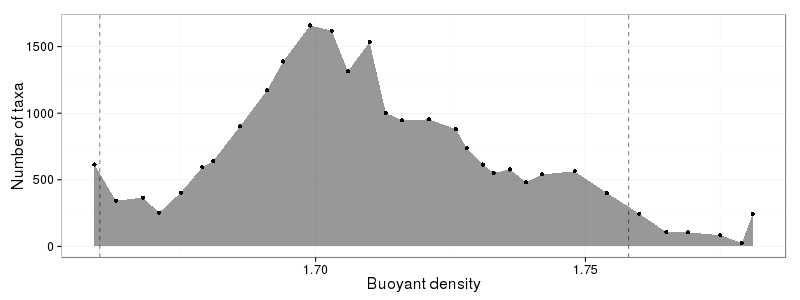

In [135]:
%%R -w 800 -h 300  -i workDir
# plotting number of taxa at each BD

tbl = read.csv('OTU_abs5e9_PCR_sub_negBin.txt', sep='\t') 

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_mid, n_taxa)) +
    geom_area(stat='identity', alpha=0.5) +
    geom_point() +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

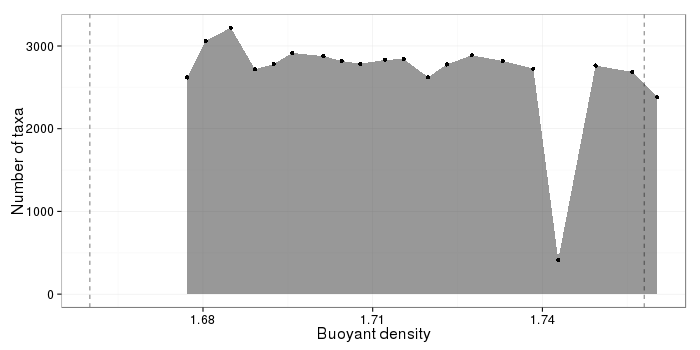

In [136]:
%%R -w 700 -h 350

tbl.true.j.s = tbl.true.j %>%
    filter(count > 0) %>%
    group_by(sample, Density) %>%
    summarize(n_taxa = sum(count > 0))

ggplot(tbl.true.j.s, aes(Density, n_taxa)) +
    geom_area(stat='identity', alpha=0.5) +
    geom_point() +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

### Plotting total counts for each sample

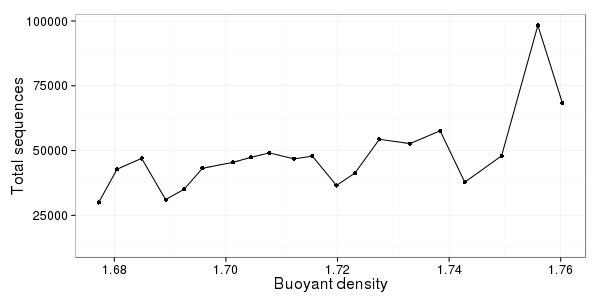

In [137]:
%%R -h 300 -w 600
tbl.true.j.s = tbl.true.j %>%
    group_by(sample, Density) %>%
    summarize(total_count = sum(count)) 

ggplot(tbl.true.j.s, aes(Density, total_count)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

### Plotting abundance distribution of target OTUs

In [138]:
%%R
tbl.true.j.f = tbl.true.j %>%
    filter(OTUId %in% targets) %>%
    arrange(OTUId, Density) %>%
    group_by(sample)
tbl.true.j.f %>% head(n=3) %>% as.data.frame

  OTUId           sample count  rel_abund FractionNum Bulk Control CC X100 X700
1 OTU.1 12C.700.14.06.23   736 0.02455871          23    0       1  0    0    1
2 OTU.1 12C.700.14.06.22  1229 0.02870556          22    0       1  0    0    1
3 OTU.1 12C.700.14.06.21  1560 0.03320067          21    0       1  0    0    1
  H2O Day Density rep contolVlabel Treatment
1   0  14  1.6772          control    12C700
2   0  14  1.6805          control    12C700
3   0  14  1.6849          control    12C700


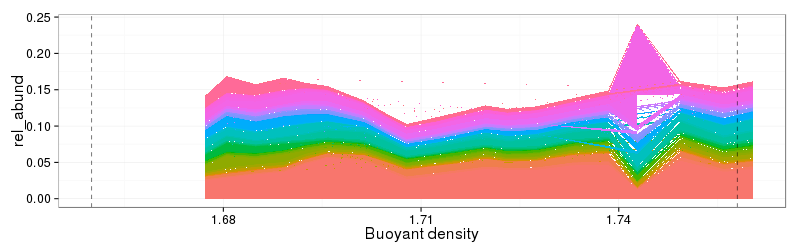

In [139]:
%%R -w 800 -h 250
# plotting relative abundances

## plot
ggplot(tbl.true.j.f, aes(Density, rel_abund, fill=OTUId)) +
    geom_area(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

## Combining true and simulated OTU tables for target taxa

In [140]:
%%R
tbl.f.e = tbl.f %>%
    mutate(library = 'simulation') %>%
    rename('density' = BD_mid) %>%
    select(-BD_min, -BD_max)

tbl.true.e = tbl.true.j.f %>% 
    select('taxon' = OTUId,
           'fraction' = sample,
           'density' = Density,
           count, rel_abund) %>%
    mutate(library = 'true') 
           
           
tbl.sim.true = rbind(tbl.f.e, tbl.true.e) %>% as.data.frame
tbl.f.e = data.frame()
tbl.true.e = data.frame()

tbl.sim.true %>% head(n=3)

     library    fraction taxon density count rel_abund
1 simulation  -inf-1.660 OTU.1   1.659     0         0
2 simulation 1.660-1.666 OTU.1   1.663     0         0
3 simulation 1.666-1.670 OTU.1   1.668     0         0


In [141]:
%%R
# check
cat('Number of target taxa: ', tbl.sim.true$taxon %>% unique %>% length, '\n')

Number of target taxa:  198 


## Abundance distributions of each target taxon

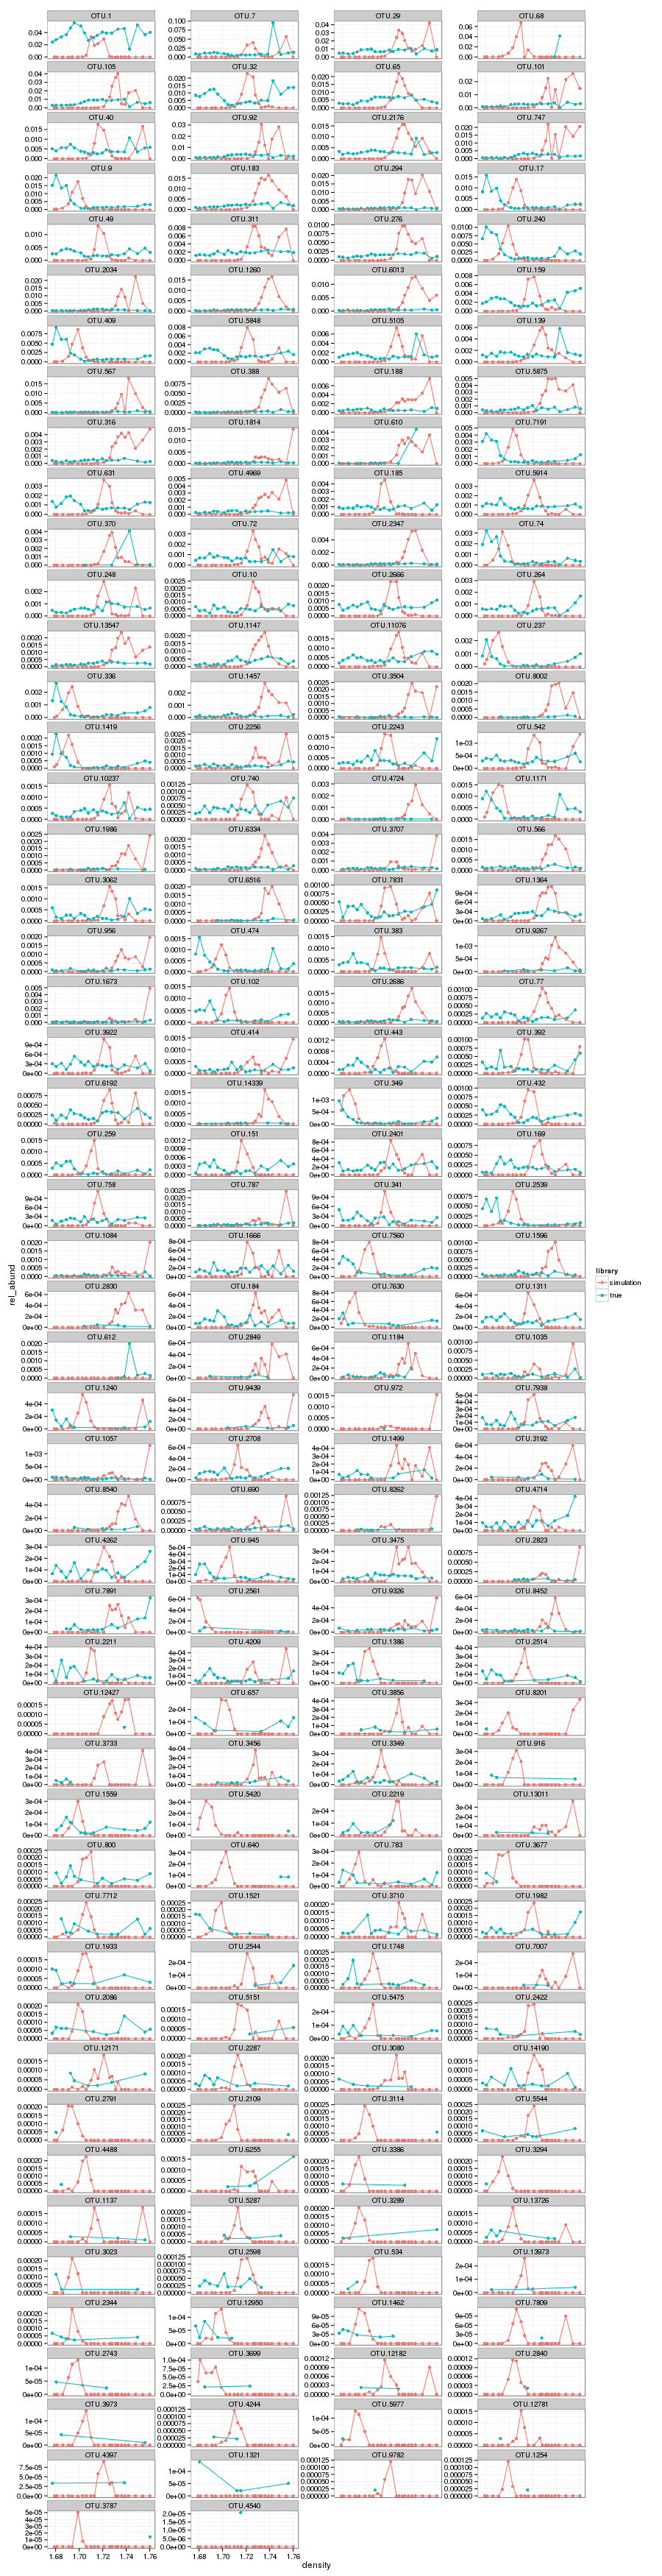

In [142]:
%%R -w 900 -h 3500

tbl.sim.true.f = tbl.sim.true %>%
    ungroup() %>%
    filter(density >= 1.6772) %>%
    filter(density <= 1.7603) %>%
    group_by(taxon) %>%
    mutate(mean_rel_abund = mean(rel_abund))  %>%
    ungroup()

tbl.sim.true.f$taxon = reorder(tbl.sim.true.f$taxon, -tbl.sim.true.f$mean_rel_abund)

ggplot(tbl.sim.true.f, aes(density, rel_abund, color=library)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    facet_wrap(~ taxon, ncol=4, scales='free_y')